## Neural Network Classification with TensorFlow

Okay, we've seen how to deal with a regression problem in TensorFlow, let's look at how we can approach a classification problem.

A classification problem involves predicting whether something is one thing or another.

For example, you might want to:

* Predict whether or not someone has heart disease based on their health parameters. This is called **binary classification** since there are only two options.
* Decide whether a photo of is of food, a person or a dog. This is called **multi-class classification** since there are more than two options.
* Predict what categories should be assigned to a Wikipedia article. This is called **multi-label classification** since a single article could have more than one category assigned.

In this notebook, we're going to work through a number of different classification problems with TensorFlow. In other words, taking a set of inputs and predicting what class those set of inputs belong to.

## What we're going to cover

Specifically, we're going to go through doing the following with TensorFlow:

* Architecture of a classification model
* Input shapes and output shapes
    * X: features/data (inputs)
    * y: labels (outputs)
        * "What class do the inputs belong to?"
* Creating custom data to view and fit
* Steps in modelling for binary and mutliclass classification
    * Creating a model
    * Compiling a model
        * Defining a loss function
        * Setting up an optimizer
        * Finding the best learning rate
        * Creating evaluation metrics
    * Fitting a model (getting it to find patterns in our data)
    * Improving a model
* The power of non-linearity
* Evaluating classification models
    * Visualizng the model ("visualize, visualize, visualize")
    * Looking at training curves
    * Compare predictions to ground truth (using our evaluation metrics)

## Typical architecture of a classification neural network

The word typical is on purpose.

Because the architecture of a classification neural network can widely vary depending on the problem you're working on.

However, there are some fundamentals all deep neural networks contain:

* An input layer.
* Some hidden layers.
* An output layer.
Much of the rest is up to the data analyst creating the model.

The following are some standard values you'll often use in your classification neural networks.
![Images/ClassificationParameters.png](Images/ClassificationParameters.png)

## Creating data to view and fit

In [6]:
import tensorflow as tf
print(tf.__version__)

Init Plugin
2.5.0
Init Graph Optimizer
Init Kernel


We could start by importing a classification dataset but let's practice making some of our own classification data.

🔑 Note: It's a common practice to get you and model you build working on a toy (or simple) dataset before moving to your actual problem. Treat it as a rehersal experiment before the actual experiment(s).

Since classification is predicting whether something is one thing or another, let's make some data to reflect that.

To do so, we'll use Scikit-Learn's **make_circles()** function.

In [7]:
from sklearn.datasets import make_circles

# Make 1000 examples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, 
                    noise=0.03, 
                    random_state=42)

In [8]:
# Check out the features
X
     

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [9]:
# See the first 10 labels
y[:10]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0])

Okay, we've seen some of our data and labels, how about we move towards visualizing?

🔑 Note: One important step of starting any kind of machine learning project is to become one with the data. And one of the best ways to do this is to visualize the data you're working with as much as possible. The data explorer's motto is "visualize, visualize, visualize".

We'll start with a DataFrame.

In [10]:
# Make dataframe of features and labels
import pandas as pd
circles = pd.DataFrame({"X0":X[:, 0], "X1":X[:, 1], "label":y})
circles.head()

X0        X1  label
0  0.754246  0.231481      1
1 -0.756159  0.153259      1
2 -0.815392  0.173282      1
3 -0.393731  0.692883      1
4  0.442208 -0.896723      0

In [11]:
# Check out the different labels
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

Alright, looks like we're dealing with a binary classification problem. It's binary because there are only two labels (0 or 1).

If there were more label options (e.g. 0, 1, 2, 3 or 4), it would be called multiclass classification.

Let's take our visualization a step further and plot our data.

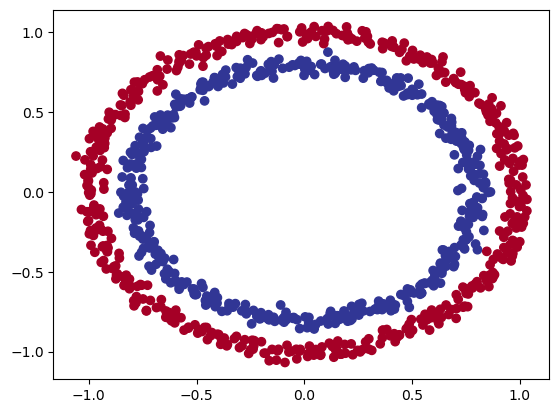

In [12]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

Nice! From the plot, can you guess what kind of model we might want to build?

How about we try and build one to classify blue or red dots? As in, a model which is able to distinguish blue from red dots.

🛠 Practice: Before pushing forward, you might want to spend 10 minutes playing around with the [TensorFlow Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle®Dataset=reg-plane&learningRate=0.03®ularizationRate=0&noise=0&networkShape=2,2&seed=0.93799&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false®ularization_hide=true®ularizationRate_hide=true&batchSize_hide=true). Try adjusting the different hyperparameters you see and click play to see a neural network train. I think you'll find the data very similar to what we've just created.

## Input and output shapes

One of the most common issues you'll run into when building neural networks is shape mismatches.

More specifically, the shape of the input data and the shape of the output data.

In our case, we want to input X and get our model to predict y.

So let's check out the shapes of X and y.

In [13]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [14]:
# Check how many samples we have
len(X), len(y)

(1000, 1000)

So we've got as many X values as we do y values, that makes sense.

Let's check out one example of each.

In [15]:
# View the first example of features and labels
X[0], y[0]

(array([0.75424625, 0.23148074]), 1)

## Steps in modelling

Now we know what data we have as well as the input and output shapes, let's see how we'd build a neural network to model it.

In TensorFlow, there are typically 3 fundamental steps to creating and training a model.

1. Creating a model - piece together the layers of a neural network yourself (using the functional or sequential API) or import a previously built model (known as transfer learning).
2. Compiling a model - defining how a model's performance should be measured (loss/metrics) as well as defining how it should improve (optimizer).
3. Fitting a model - letting the model try to find patterns in the data (how does X get to y).
Let's see these in action using the Sequential API to build a model for our regression data. And then we'll step through each.

In [16]:
# Set random seed
tf.random.set_seed(42)

# 1. Create the model using the Sequential API
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(), # binary since we are working with 2 clases (0 & 1)
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['accuracy'])

# 3. Fit the model
model_1.fit(X, y, epochs=5)

Metal device set to: Apple M1
Epoch 1/5


2022-12-06 22:33:44.311757: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-06 22:33:44.312144: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-12-06 22:33:44.414014: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-06 22:33:44.414229: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-06 22:33:44.715802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 2s 5ms/step - loss: 5.4350 - accuracy: 0.4790
Epoch 2/5
32/32 [==============================] - 0s 4ms/step - loss: 3.8813 - accuracy: 0.4700
Epoch 3/5
32/32 [==============================] - 0s 4ms/step - loss: 0.7756 - accuracy: 0.4930
Epoch 4/5
32/32 [==============================] - 0s 4ms/step - loss: 0.7155 - accuracy: 0.4940
Epoch 5/5
32/32 [==============================] - 0s 4ms/step - loss: 0.7009 - accuracy: 0.4920


Looking at the accuracy metric, our model performs poorly (50% accuracy on a binary classification problem is the equivalent of guessing), but what if we trained it for longer?

In [17]:
# Train our model for longer (more chances to look at the data)
model_1.fit(X, y, epochs=200, verbose=0) # set verbose=0 to remove training updates
model_1.evaluate(X, y)

32/32 [==============================] - 0s 3ms/step - loss: 0.6935 - accuracy: 0.5000


2022-12-06 22:36:48.634943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[0.6934829950332642, 0.5]

Even after 200 passes of the data, it's still performing as if it's guessing.

What if we added an extra layer and trained for a little longer?

In [18]:
# Set random seed
tf.random.set_seed(42)

# 1. Create the model (same as model_1 but with an extra layer)
model_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(1), # add an extra layer
  tf.keras.layers.Dense(1) 
])

# 2. Compile the model
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['accuracy'])

# 3. Fit the model
model_2.fit(X, y, epochs=100, verbose=0) # set verbose=0 to make the output print less

2022-12-06 22:37:27.148069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [19]:
# Evaluate the model
model_2.evaluate(X, y)

32/32 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5000


2022-12-06 22:37:44.437192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[0.6932641863822937, 0.5]

## Improving a model

To improve our model, we can alter almost every part of the 3 steps we went through before.

1. **Creating a model** - here you might want to add more layers, increase the number of hidden units (also called neurons) within each layer, change the activation functions of each layer.
2. **Compiling a model** - you might want to choose a different optimization function (such as the Adam optimizer, which is usually pretty good for many problems) or perhaps change the learning rate of the optimization function.
3. **Fitting a model** - perhaps you could fit a model for more epochs (leave it training for longer).


In [20]:
# Set random seed
tf.random.set_seed(42)

# 1. Create the model (this time 3 layers)
model_3 = tf.keras.Sequential([
  # Before TensorFlow 2.7.0
  # tf.keras.layers.Dense(100), # add 100 dense neurons

  # With TensorFlow 2.7.0
  # tf.keras.layers.Dense(100, input_shape=(None, 1)), # add 100 dense neurons

  ## After TensorFlow 2.8.0 ##
  tf.keras.layers.Dense(100), # add 100 dense neurons
  tf.keras.layers.Dense(10), # add another layer with 10 neurons
  tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(), # use Adam instead of SGD
                metrics=['accuracy'])

# 3. Fit the model
model_3.fit(X, y, epochs=100, verbose=1) # fit for 100 passes of the data

Epoch 1/100


2022-12-06 22:44:42.807232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 2s 14ms/step - loss: 2.7522 - accuracy: 0.4660
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 0.7083 - accuracy: 0.4770
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5030
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 0.6960 - accuracy: 0.4940
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.6957 - accuracy: 0.4840
Epoch 6/100
32/32 [==============================] - 0s 6ms/step - loss: 0.6958 - accuracy: 0.4510
Epoch 7/100
32/32 [==============================] - 0s 6ms/step - loss: 0.6952 - accuracy: 0.5240
Epoch 8/100
32/32 [==============================] - 0s 5ms/step - loss: 0.6956 - accuracy: 0.4990
Epoch 9/100
32/32 [==============================] - 0s 5ms/step - loss: 0.6969 - accuracy: 0.4890
Epoch 10/100
32/32 [==============================] - 0s 6ms/step - loss: 0.6952 - accuracy: 0.4650
Epoch 11/100
32/32 [

32/32 [==============================] - 0s 5ms/step - loss: 0.7003 - accuracy: 0.4600
Epoch 84/100
32/32 [==============================] - 0s 5ms/step - loss: 0.6979 - accuracy: 0.5150
Epoch 85/100
32/32 [==============================] - 0s 5ms/step - loss: 0.6974 - accuracy: 0.4800
Epoch 86/100
32/32 [==============================] - 0s 5ms/step - loss: 0.7020 - accuracy: 0.4890
Epoch 87/100
32/32 [==============================] - 0s 5ms/step - loss: 0.6990 - accuracy: 0.4620
Epoch 88/100
32/32 [==============================] - 0s 5ms/step - loss: 0.6998 - accuracy: 0.4680
Epoch 89/100
32/32 [==============================] - 0s 5ms/step - loss: 0.6990 - accuracy: 0.4760
Epoch 90/100
32/32 [==============================] - 0s 5ms/step - loss: 0.6986 - accuracy: 0.4870
Epoch 91/100
32/32 [==============================] - 0s 5ms/step - loss: 0.7001 - accuracy: 0.4910
Epoch 92/100
32/32 [==============================] - 0s 5ms/step - loss: 0.7011 - accuracy: 0.4900
Epoch 93/100


In [21]:
import numpy as np

To visualize our model's predictions we're going to create a function plot_decision_boundary() which:

* Takes in a trained model, features (X) and labels (y).
* Creates a meshgrid of the different X values.
* Makes predictions across the meshgrid.
* Plots the predictions as well as a line between the different zones (where each unique class falls).

In [23]:
def plot_decision_boundary(model, X, y):
    """
    Plots the decision boundary created by a model predicting on X.
  This function has been adapted from two phenomenal resources:
   1. CS231n - https://cs231n.github.io/neural-networks-case-study/
   2. Made with ML basics - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
    """
    # Define the axis boundaries of the plot and create a meshgrid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))
    # Create X values (we're going to predict on all of these)
    x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together: https://numpy.org/devdocs/reference/generated/numpy.c_.html
    
    # Make predictions using the trained model
    y_pred = model.predict(x_in)
    
    # Check for multi-class
    if model.output_shape[-1] > 1: # checks the final dimension of the model's output shape, if this is > (greater than) 1, it's multi-class
        #another way to check is if len(y_pred[0]) > 1
        print("doing multiclass classification...")
        # We have to reshape our predictions to get them ready for plotting
        y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
    else:
        print("doing binary classifcation...")
        y_pred = np.round(np.max(y_pred, axis=1)).reshape(xx.shape)
        
    # Plot decision boundary
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

Now we've got a function to plot our model's decision boundary (the cut off point its making between red and blue dots), let's try it out.

2022-12-08 15:37:28.475355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


doing binary classifcation...


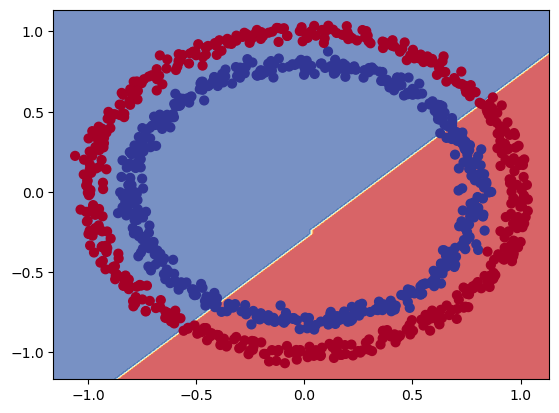

In [24]:
# Check out the predictions our model is making
plot_decision_boundary(model_3, X, y)

Looks like our model is trying to draw a straight line through the data.

What's wrong with doing this?

The main issue is our data isn't separable by a straight line.

In a regression problem, our model might work. In fact, let's try it.

In [25]:
# Set random seed
tf.random.set_seed(42)

# Create some regression data
X_regression = np.arange(0, 1000, 5)
y_regression = np.arange(100, 1100, 5)

# Split it into training and test sets
X_reg_train = X_regression[:150]
X_reg_test = X_regression[150:]
y_reg_train = y_regression[:150]
y_reg_test = y_regression[150:]

# Fit our model to the data
# Note: Before TensorFlow 2.7.0, this line would work
# model_3.fit(X_reg_train, y_reg_train, epochs=100)

# After TensorFlow 2.7.0, see here for more: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/278
model_3.fit(tf.expand_dims(X_reg_train, axis=-1), 
            y_reg_train,
            epochs=100)

Epoch 1/100


ValueError: in user code:

    /opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:855 train_function  *
        return step_function(self, iterator)
    /opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:838 run_step  **
        outputs = model.train_step(data)
    /opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:795 train_step
        y_pred = self(x, training=True)
    /opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:251 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_2 is incompatible with the layer: expected axis -1 of input shape to have value 2 but received input with shape (None, 1)


In [26]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 1,321
Trainable params: 1,321
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Setup random seed
tf.random.set_seed(42)

# Recreate the model
model_3 = tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Dense(1)
])

# Change the loss and metrics of our compiled model
model_3.compile(loss=tf.keras.losses.mae, # change the loss function to be regression-specific
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae']) # change the metric to be regression-specific

# Fit the recompiled model
model_3.fit(tf.expand_dims(X_reg_train, axis=-1), 
            y_reg_train, 
            epochs=100)

Epoch 1/100


2022-12-08 15:39:55.961628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 1s 50ms/step - loss: 381.7863 - mae: 381.7863
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 251.0487 - mae: 251.0487
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: 123.1813 - mae: 123.1813
Epoch 4/100
5/5 [==============================] - 0s 5ms/step - loss: 52.6976 - mae: 52.6976
Epoch 5/100
5/5 [==============================] - 0s 5ms/step - loss: 84.7232 - mae: 84.7232
Epoch 6/100
5/5 [==============================] - 0s 5ms/step - loss: 65.6600 - mae: 65.6600
Epoch 7/100
5/5 [==============================] - 0s 5ms/step - loss: 44.0792 - mae: 44.0792
Epoch 8/100
5/5 [==============================] - 0s 5ms/step - loss: 51.1722 - mae: 51.1722
Epoch 9/100
5/5 [==============================] - 0s 5ms/step - loss: 42.3288 - mae: 42.3288
Epoch 10/100
5/5 [==============================] - 0s 5ms/step - loss: 44.6028 - mae: 44.6028
Epoch 11/100
5/5 [==============================] - 0s 5ms/step 

5/5 [==============================] - 0s 5ms/step - loss: 37.8672 - mae: 37.8672
Epoch 88/100
5/5 [==============================] - 0s 5ms/step - loss: 38.4229 - mae: 38.4229
Epoch 89/100
5/5 [==============================] - 0s 5ms/step - loss: 37.9808 - mae: 37.9808
Epoch 90/100
5/5 [==============================] - 0s 5ms/step - loss: 37.7132 - mae: 37.7132
Epoch 91/100
5/5 [==============================] - 0s 5ms/step - loss: 37.6008 - mae: 37.6008
Epoch 92/100
5/5 [==============================] - 0s 5ms/step - loss: 37.7689 - mae: 37.7689
Epoch 93/100
5/5 [==============================] - 0s 5ms/step - loss: 38.1388 - mae: 38.1388
Epoch 94/100
5/5 [==============================] - 0s 5ms/step - loss: 37.4237 - mae: 37.4237
Epoch 95/100
5/5 [==============================] - 0s 5ms/step - loss: 37.3958 - mae: 37.3958
Epoch 96/100
5/5 [==============================] - 0s 5ms/step - loss: 37.8458 - mae: 37.8458
Epoch 97/100
5/5 [==============================] - 0s 5ms/step

2022-12-08 15:41:38.606308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


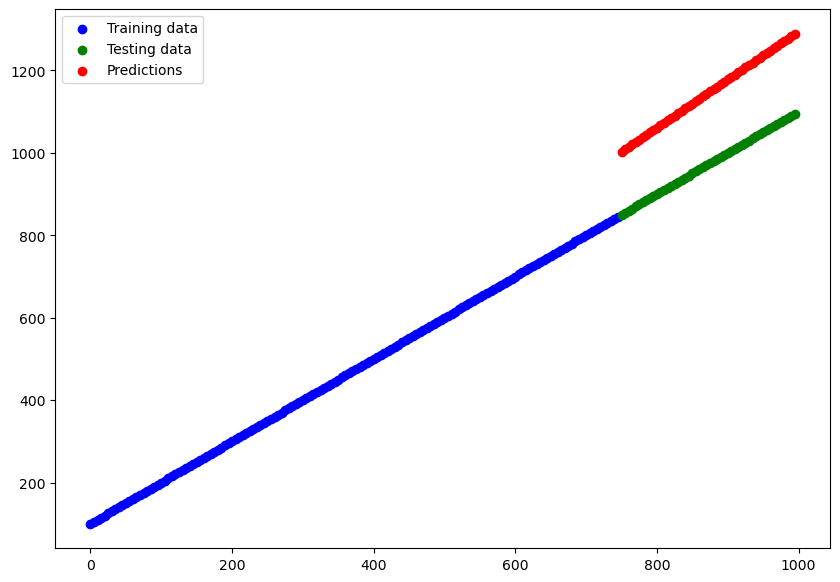

In [28]:
# Make predictions with our trained model
y_reg_preds = model_3.predict(y_reg_test)

# Plot the model's predictions against our regression data
plt.figure(figsize=(10, 7))
plt.scatter(X_reg_train, y_reg_train, c='b', label='Training data')
plt.scatter(X_reg_test, y_reg_test, c='g', label='Testing data')
plt.scatter(X_reg_test, y_reg_preds.squeeze(), c='r', label='Predictions')
plt.legend();

Okay, the predictions aren't perfect (if the predictions were perfect, the red would line up with the green), but they look better than complete guessing.

So this means our model must be learning something...

There must be something we're missing out on for our classification problem.

## The missing piece: Non-linearity

Okay, so we saw our neural network can model straight lines (with ability a little bit better than guessing).

##### What about non-straight (non-linear) lines?

If we're going to model our classification data (the red and clue circles), we're going to need some non-linear lines.

🔨 Practice: Before we get to the next steps, I'd encourage you to play around with the [TensorFlow Playground](https://playground.tensorflow.org/#activation=linear&batchSize=1&dataset=circle®Dataset=reg-plane&learningRate=0.01®ularizationRate=0&noise=0&networkShape=1&seed=0.09561&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false®ularizationRate_hide=true&discretize_hide=true®ularization_hide=true&dataset_hide=true&noise_hide=true&batchSize_hide=true) (check out what the data has in common with our own classification data) for 10-minutes. In particular the tab which says "activation". Once you're done, come back.

Did you try out the activation options? If so, what did you find?

If you didn't, don't worry, let's see it in code.

We're going to replicate the neural network you can see at this link: [TensorFlow Playground](https://playground.tensorflow.org/#activation=linear&batchSize=1&dataset=circle®Dataset=reg-plane&learningRate=0.01®ularizationRate=0&noise=0&networkShape=1&seed=0.09561&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false®ularizationRate_hide=true&discretize_hide=true®ularization_hide=true&dataset_hide=true&noise_hide=true&batchSize_hide=true).

The neural network we're going to recreate with TensorFlow code. See it live at [TensorFlow Playground](https://playground.tensorflow.org/#activation=linear&batchSize=1&dataset=circle®Dataset=reg-plane&learningRate=0.01®ularizationRate=0&noise=0&networkShape=1&seed=0.09561&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false®ularizationRate_hide=true&discretize_hide=true®ularization_hide=true&dataset_hide=true&noise_hide=true&batchSize_hide=true).

The main change we'll add to models we've built before is the use of the ```activation``` keyword.

In [29]:
# Set the random seed
tf.random.set_seed(42)

# Create the model
model_4 = tf.keras.Sequential([
  tf.keras.layers.Dense(1, activation=tf.keras.activations.linear), # 1 hidden layer with linear activation
  tf.keras.layers.Dense(1) # output layer
])

# Compile the model
model_4.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # note: "lr" used to be what was used, now "learning_rate" is favoured
                metrics=["accuracy"])

# Fit the model
history = model_4.fit(X, y, epochs=100)

Epoch 1/100
23/32 [====================>.........] - ETA: 0s - loss: 4.4109 - accuracy: 0.4905

2022-12-08 15:46:45.342957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step - loss: 4.3122 - accuracy: 0.5000
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 4.1897 - accuracy: 0.5000
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 4.1114 - accuracy: 0.5000
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 4.0549 - accuracy: 0.5000
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 3.9941 - accuracy: 0.5000
Epoch 6/100
32/32 [==============================] - 0s 5ms/step - loss: 3.9588 - accuracy: 0.5000
Epoch 7/100
32/32 [==============================] - 0s 5ms/step - loss: 3.9344 - accuracy: 0.5000
Epoch 8/100
32/32 [==============================] - 0s 5ms/step - loss: 3.8734 - accuracy: 0.5000
Epoch 9/100
32/32 [==============================] - 0s 5ms/step - loss: 3.8261 - accuracy: 0.5000
Epoch 10/100
32/32 [==============================] - 0s 5ms/step - loss: 3.7734 - accuracy: 0.5000
Epoch 11/100
32/32 [=

32/32 [==============================] - 0s 5ms/step - loss: 0.7683 - accuracy: 0.5000
Epoch 84/100
32/32 [==============================] - 0s 5ms/step - loss: 0.7663 - accuracy: 0.5000
Epoch 85/100
32/32 [==============================] - 0s 5ms/step - loss: 0.7643 - accuracy: 0.5000
Epoch 86/100
32/32 [==============================] - 0s 5ms/step - loss: 0.7624 - accuracy: 0.5000
Epoch 87/100
32/32 [==============================] - 0s 5ms/step - loss: 0.7605 - accuracy: 0.5000
Epoch 88/100
32/32 [==============================] - 0s 4ms/step - loss: 0.7587 - accuracy: 0.5000
Epoch 89/100
32/32 [==============================] - 0s 5ms/step - loss: 0.7570 - accuracy: 0.5000
Epoch 90/100
32/32 [==============================] - 0s 5ms/step - loss: 0.7552 - accuracy: 0.5000
Epoch 91/100
32/32 [==============================] - 0s 5ms/step - loss: 0.7535 - accuracy: 0.5000
Epoch 92/100
32/32 [==============================] - 0s 5ms/step - loss: 0.7518 - accuracy: 0.5000
Epoch 93/100


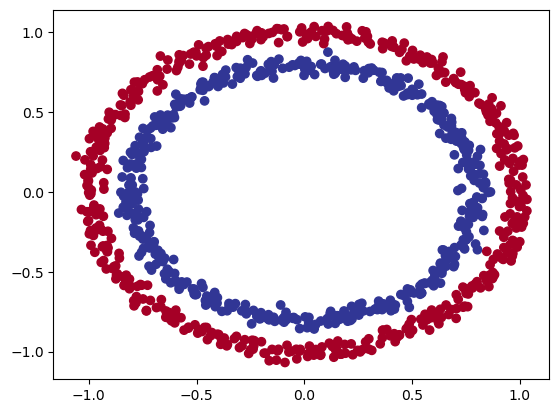

In [30]:
# Check out our data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

2022-12-08 15:47:52.950141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


doing binary classifcation...


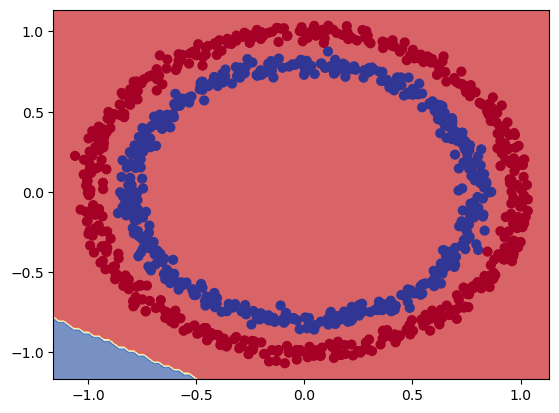

In [31]:
# Check the deicison boundary (blue is blue class, yellow is the crossover, red is red class)
plot_decision_boundary(model_4, X, y)

Well, it looks like we're getting a straight (linear) line prediction again.

But our data is non-linear (not a straight line)...

What we're going to have to do is add some non-linearity to our model.

To do so, we'll use the activation parameter in on of our layers.

In [32]:
# Set random seed
tf.random.set_seed(42)

# Create a model with a non-linear activation
model_5 = tf.keras.Sequential([
  tf.keras.layers.Dense(1, activation=tf.keras.activations.relu), # can also do activation='relu'
  tf.keras.layers.Dense(1) # output layer 
])

# Compile the model
model_5.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history = model_5.fit(X, y, epochs=100)

Epoch 1/100
11/32 [=========>....................] - ETA: 0s - loss: 2.2161 - accuracy: 0.4858

2022-12-08 15:50:07.387025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step - loss: 1.8235 - accuracy: 0.5000
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 1.4428 - accuracy: 0.5000
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 1.3410 - accuracy: 0.4970
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 1.2734 - accuracy: 0.4520
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 1.2212 - accuracy: 0.4230
Epoch 6/100
32/32 [==============================] - 0s 5ms/step - loss: 1.1797 - accuracy: 0.4080
Epoch 7/100
32/32 [==============================] - 0s 5ms/step - loss: 1.1466 - accuracy: 0.4230
Epoch 8/100
32/32 [==============================] - 0s 5ms/step - loss: 1.1192 - accuracy: 0.4440
Epoch 9/100
32/32 [==============================] - 0s 6ms/step - loss: 1.0954 - accuracy: 0.4460
Epoch 10/100
32/32 [==============================] - 0s 6ms/step - loss: 1.0739 - accuracy: 0.4510
Epoch 11/100
32/32 [=

32/32 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.4800
Epoch 84/100
32/32 [==============================] - 0s 5ms/step - loss: 0.6933 - accuracy: 0.5050
Epoch 85/100
32/32 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.5160
Epoch 86/100
32/32 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.5170
Epoch 87/100
32/32 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.5090
Epoch 88/100
32/32 [==============================] - 0s 5ms/step - loss: 0.6933 - accuracy: 0.4970
Epoch 89/100
32/32 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.4830
Epoch 90/100
32/32 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.4640
Epoch 91/100
32/32 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.4660
Epoch 92/100
32/32 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.5060
Epoch 93/100


Hmm... still not learning...

What we if increased the number of neurons and layers?

Say, 2 hidden layers, with ReLU, pronounced "rel-u", (short for rectified linear unit), activation on the first one, and 4 neurons each?



In [33]:
# Set random seed
tf.random.set_seed(42)

# Create a model
model_6 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 1, 4 neurons, ReLU activation
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 2, 4 neurons, ReLU activation
  tf.keras.layers.Dense(1) # ouput layer
])

# Compile the model
model_6.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(lr=0.001), # Adam's default learning rate is 0.001
                metrics=['accuracy'])

# Fit the model
history = model_6.fit(X, y, epochs=100)
     

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-12-08 15:51:18.870673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100
32/32 [==============================] - 1s 6ms/step - loss: 3.4097 - accuracy: 0.4980
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 1.4906 - accuracy: 0.4520
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 1.3197 - accuracy: 0.4580
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 1.2386 - accuracy: 0.4740
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 1.1746 - accuracy: 0.4710
Epoch 6/100
32/32 [==============================] - 0s 6ms/step - loss: 1.1141 - accuracy: 0.4710
Epoch 7/100
32/32 [==============================] - 0s 6ms/step - loss: 1.0581 - accuracy: 0.4750
Epoch 8/100
32/32 [==============================] - 0s 6ms/step - loss: 0.9958 - accuracy: 0.4790
Epoch 9/100
32/32 [==============================] - 0s 6ms/step - loss: 0.9131 - accuracy: 0.4870
Epoch 10/100
32/32 [==============================] - 0s 6ms/step - loss: 0.8328 - accuracy: 0.4850
Epoch 11/

32/32 [==============================] - 0s 5ms/step - loss: 0.4978 - accuracy: 0.8170
Epoch 84/100
32/32 [==============================] - 0s 5ms/step - loss: 0.4900 - accuracy: 0.8210
Epoch 85/100
32/32 [==============================] - 0s 5ms/step - loss: 0.4819 - accuracy: 0.8410
Epoch 86/100
32/32 [==============================] - 0s 5ms/step - loss: 0.4757 - accuracy: 0.8630
Epoch 87/100
32/32 [==============================] - 0s 6ms/step - loss: 0.4675 - accuracy: 0.8790
Epoch 88/100
32/32 [==============================] - 0s 6ms/step - loss: 0.4587 - accuracy: 0.8900
Epoch 89/100
32/32 [==============================] - 0s 6ms/step - loss: 0.4507 - accuracy: 0.8900
Epoch 90/100
32/32 [==============================] - 0s 6ms/step - loss: 0.4443 - accuracy: 0.8950
Epoch 91/100
32/32 [==============================] - 0s 5ms/step - loss: 0.4368 - accuracy: 0.8860
Epoch 92/100
32/32 [==============================] - 0s 5ms/step - loss: 0.4269 - accuracy: 0.8810
Epoch 93/100


In [34]:
# Evaluate the model
model_6.evaluate(X, y)

32/32 [==============================] - 0s 4ms/step - loss: 0.3543 - accuracy: 0.9150


2022-12-08 15:52:11.675331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[0.35429251194000244, 0.9150000214576721]

2022-12-08 15:52:31.394489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


doing binary classifcation...


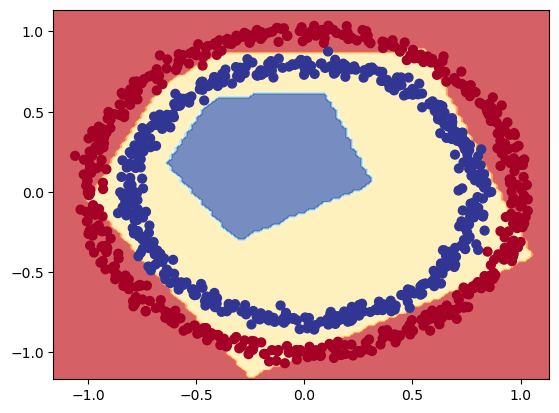

In [35]:
# Check out the predictions using 2 hidden layers
plot_decision_boundary(model_6, X, y)

What gives?

It seems like our model is the same as the one in the TensorFlow Playground but model it's still drawing straight lines...

Ideally, the yellow lines go on the inside of the red circle and the blue circle.

Okay, okay, let's model this circle once and for all.

One more model (I promise... actually, I'm going to have to break that promise... we'll be building plenty more models).

This time we'll change the activation function on our output layer too. Remember the architecture of a classification model? For binary classification, the output layer activation is usually the Sigmoid activation function.

In [36]:
# Set random seed
tf.random.set_seed(42)

# Create a model
model_7 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 1, ReLU activation
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 2, ReLU activation
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid) # ouput layer, sigmoid activation
])

# Compile the model
model_7.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
history = model_7.fit(X, y, epochs=100, verbose=0)

2022-12-08 15:53:23.470147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [37]:
# Evaluate our model
model_7.evaluate(X, y)

32/32 [==============================] - 0s 4ms/step - loss: 0.4560 - accuracy: 0.8730


2022-12-08 15:53:37.850497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[0.456043541431427, 0.8730000257492065]

Woah! It looks like our model is getting some incredible results, let's check them out.

2022-12-08 15:54:15.754947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


doing binary classifcation...


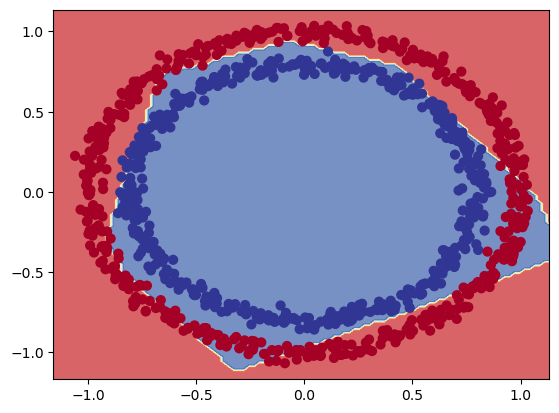

In [39]:
# View the predictions of the model with relu and sigmoid activations
plot_decision_boundary(model_7, X, y)

Nice! It looks like our model is almost perfectly (apart from a few examples) separating the two circles.

🤔 Question: What's wrong with the predictions we've made? Are we really evaluating our model correctly here? Hint: what data did the model learn on and what did we predict on?

Before we answer that, it's important to recognize what we've just covered.

🔑 Note: The combination of linear (straight lines) and non-linear (non-straight lines) functions is one of the key fundamentals of neural networks.

Think of it like this:

If I gave you an unlimited amount of straight lines and non-straight lines, what kind of patterns could you draw?

That's essentially what neural networks do to find patterns in data.

Now you might be thinking, "but I haven't seen a linear function or a non-linear function before..."

Oh but you have.

We've been using them the whole time.

They're what power the layers in the models we just built.

To get some intuition about the activation functions we've just used, let's create them and then try them on some toy data.

In [40]:
# Create a toy tensor (similar to the data we pass into our model)
A = tf.cast(tf.range(-10, 10), tf.float32)
A

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
      dtype=float32)>

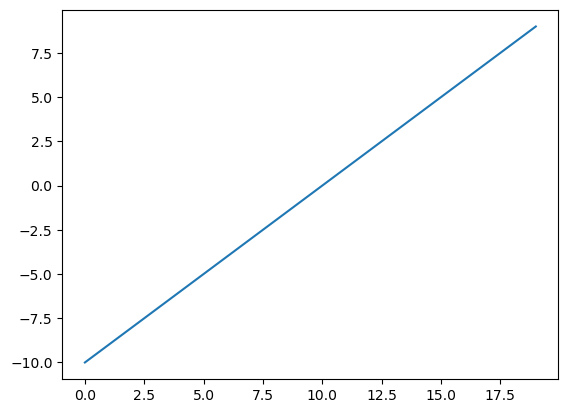

In [41]:
# Visualize our toy tensor
plt.plot(A);

A straight (linear) line!

Nice, now let's recreate the sigmoid function and see what it does to our data. You can also find a pre-built sigmoid function at tf.keras.activations.sigmoid.

In [42]:
# Sigmoid - https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid
def sigmoid(x):
    return 1 / (1 + tf.exp(-x))

# Use the sigmoid function on our tensor
sigmoid(A)

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([4.53978682e-05, 1.23394624e-04, 3.35350167e-04, 9.11051058e-04,
       2.47262395e-03, 6.69285096e-03, 1.79862101e-02, 4.74258773e-02,
       1.19202934e-01, 2.68941432e-01, 5.00000000e-01, 7.31058598e-01,
       8.80797148e-01, 9.52574134e-01, 9.82013762e-01, 9.93307173e-01,
       9.97527421e-01, 9.99089003e-01, 9.99664664e-01, 9.99876618e-01],
      dtype=float32)>

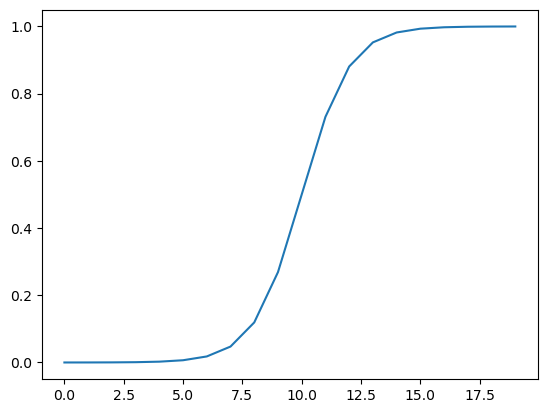

In [43]:
# Plot sigmoid modified tensor
plt.plot(sigmoid(A));

A non-straight (non-linear) line!

Okay, how about the ReLU function (ReLU turns all negatives to 0 and positive numbers stay the same)?

In [44]:
# ReLU - https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu
def relu(x):
    return tf.maximum(0, x)

# Pass toy tensor through ReLU function
relu(A)

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6.,
       7., 8., 9.], dtype=float32)>

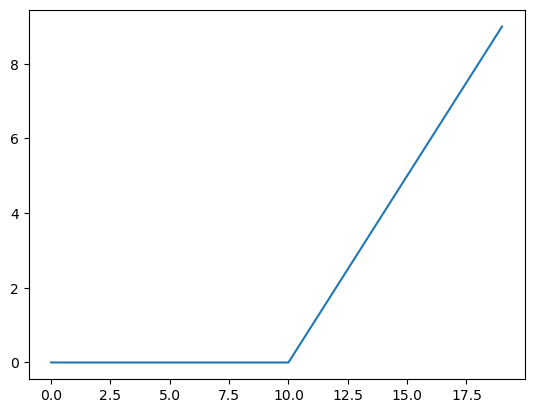

In [45]:
# Plot ReLU-modified tensor
plt.plot(relu(A));